In [1]:
import numpy as np
import time
from Model import SVM
#from DataLoader import load_data, train_valid_split
import ctypes
import torch
import pytorch_lightning as pl
import torch.utils.data as data_utils
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import random
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics import accuracy_score
from scipy import ndimage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
import pytorch_lightning as pl
import torch
from torchvision.models import resnet18
from torch import nn
from sklearn.model_selection import StratifiedKFold


/tmp/ipykernel_2147837/3914813728.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:

## Load data
mat = scipy.io.loadmat('/home/grads/s/sant1/Desktop/cybermanufacturing/Dataset/Thermal_data_tensor.mat')
thermal_data = np.array(mat['Thermal_data_tensor'], dtype=np.int16)

ground_truth = np.load('/home/grads/s/sant1/Desktop/cybermanufacturing/Dataset/ground_truth.npy')
ground_truth = np.array(ground_truth, dtype=np.float16)
labels_gt = np.where(ground_truth > 1, 1, 0)
thermal_data.shape, labels_gt.shape

((180, 8, 201, 201), (180,))

In [3]:
def result_record(file, train_acc, valid_acc,scores,test_acc=0):
    file.write('Training: \n')
    file.write('accuracy: {:.3f}% \n'.format(train_acc * 100))
    file.write('---------------------------------------------\n')
    file.write('Validation: \n')
    file.write('accuracy: {:.3f}% \n'.format(valid_acc * 100))
    file.write('---------------------------------------------\n')
    file.write('\n')
    file.write('cross validation: \n')
    file.write('accuracy: {:.3f}% \n'.format(np.mean(scores) * 100))
    file.write('---------------------------------------------\n')
    if test_acc != 0:
        file.write('Testing: \n')
        file.write('accuracy: {:.3f}% \n'.format(test_acc * 100))
        file.write('---------------------------------------------\n')
    # file.write('The total number of support vectors: \n')
    # file.write(str(np.sum(svclassifier.n_support_)) + '\n')
    file.write('\n')

In [4]:
true_samples_indices=[index for index in range(len(labels_gt)) if labels_gt[index]==1]
false_samples_indices=[index for index in range(len(labels_gt)) if labels_gt[index]==0]
print(len(true_samples_indices), len(false_samples_indices))
min_samples = min(len(true_samples_indices), len(false_samples_indices))
true_samples_withlabels =[(thermal_data[i], 1) for i in true_samples_indices]
false_samples_withlabels =[(thermal_data[i], 0) for i in false_samples_indices]


if len(true_samples_indices) > len(false_samples_indices):
    random_true_samples = random.sample(true_samples_withlabels, min_samples)
    random_false_samples = false_samples_withlabels
    # randomly shuffle the data
    
    balanced_data = random_false_samples + random_true_samples
    np.random.shuffle(balanced_data)
else:
    random_true_samples = true_samples_withlabels
    random_false_samples = random.sample(false_samples_withlabels, min_samples)
    balanced_data = random_true_samples + random_false_samples
    np.random.shuffle(balanced_data)

X = np.array([sample[0] for sample in balanced_data]) # features
y = np.array([sample[1] for sample in balanced_data]) # labels
len(X), len(y)

114 66


(132, 132)

<Axes: ylabel='Count'>

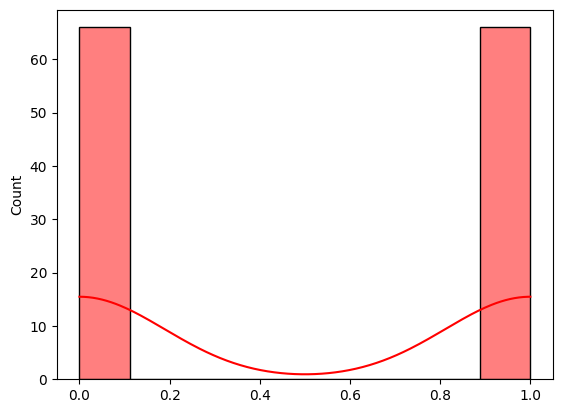

In [5]:
sns.histplot(y, kde=True, legend=True, color='red', label='Balanced Data')

In [9]:
# merge the data
# normalize the data
X.shape, y.shape
X_norm = np.zeros((len(X), 201, 201))
X_norm.shape

#X_norm_flatten=X_norm.reshape(len(X), -1)
#X_norm_flatten.shape        
# element-wise sum of the 8 frames

for i in range(len(X)):
    X_norm[i]=sum(np.array(X[i]))/8
    X_norm[i].shape
# element wise summation of numpy arrays

print(X_norm[0].shape)
"""
print(X_norm_flatten.shape)
X_norm.shape
"""
""" 
plt.imshow(X_norm[0], cmap='hot', interpolation='nearest')

fig = plt.figure(figsize=(15, 3))
for i in range(8):
    fig.add_subplot(1, 8, i+1)
    plt.imshow(X[0][i], cmap='hot', interpolation='nearest')
    plt.axis('off') 
plt.show()
"""

(201, 201)


" \nplt.imshow(X_norm[0], cmap='hot', interpolation='nearest')\n\nfig = plt.figure(figsize=(15, 3))\nfor i in range(8):\n    fig.add_subplot(1, 8, i+1)\n    plt.imshow(X[0][i], cmap='hot', interpolation='nearest')\n    plt.axis('off') \nplt.show()\n"

In [24]:
def svm_classifer1(deg,X_svm,y):
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X_svm, y)
    for train_index, test_index in skf.split(X_svm, y):
        x_train, x_valid = X_svm[train_index], X_svm[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        x_train_norm = x_train/np.max(X_svm)
        x_valid_norm = x_valid/np.max(X_svm)
        
        # flatten the data to be used in the SVM
        x_train_fin = x_train_norm.reshape(len(x_train_norm),-1)
        x_valid_fin = x_valid_norm.reshape(len(x_valid_norm),-1)
        #print(x_train_fin.shape, x_valid_fin.shape)
        
        # flatten the complete data to be used in the SVM
        X_data = X_svm/np.max(X_svm)
        X_data =X_data.reshape(X_data.shape[0],-1)
        
        time_start = time.time()
        model = svm.SVC(gamma='auto', kernel='poly', degree=deg, coef0=0, C=10)
        

      
        model.fit(x_train_fin, y_train)
        y_predict = model.predict(x_train_fin)
        train_acc = accuracy_score(y_train, y_predict)
        y_eval=model.predict(x_valid_fin)
        eval_acc = accuracy_score(y_valid, y_eval)
        scores=cross_val_score(model, X_data, y, cv=5)
        print('Train accuracy: ', train_acc)
        print('Validation accuracy: ', eval_acc)
        # cross validation with 5 folds on the complete data
        print('Cross-validation scores: ', scores)
        
        time_stop = time.time()
        with open('SVM Polynomial Kernel_proportional train and test on Merged images.txt', 'a') as f:
            f.write('SVM with polynomial kernel (degree={:.3f}) \n'.format(deg))
            f.write('Execution Time: {:.3f}s \n'.format(time_stop - time_start))
        
            result_record(f, train_acc, eval_acc, scores,0 )

In [25]:
for deg in range(10):
    svm_classifer1(deg,X_norm,y)

Train accuracy:  0.5
Validation accuracy:  0.5
Cross-validation scores:  [0.48148148 0.48148148 0.5        0.5        0.5       ]
Train accuracy:  0.5
Validation accuracy:  0.5
Cross-validation scores:  [0.48148148 0.48148148 0.5        0.5        0.5       ]
Train accuracy:  0.5
Validation accuracy:  0.5
Cross-validation scores:  [0.48148148 0.48148148 0.5        0.5        0.5       ]
Train accuracy:  0.625
Validation accuracy:  0.45454545454545453
Cross-validation scores:  [0.37037037 0.48148148 0.5        0.53846154 0.53846154]
Train accuracy:  0.5340909090909091
Validation accuracy:  0.45454545454545453
Cross-validation scores:  [0.37037037 0.48148148 0.5        0.53846154 0.53846154]
Train accuracy:  0.5568181818181818
Validation accuracy:  0.5227272727272727
Cross-validation scores:  [0.37037037 0.48148148 0.5        0.53846154 0.53846154]
Train accuracy:  0.6136363636363636
Validation accuracy:  0.4090909090909091
Cross-validation scores:  [0.48148148 0.48148148 0.57692308 0.53

In [ ]:
class TISVM(object):
    def __init__(self, degree):
        self.degree = degree

    def ti_kernel(self, x, y):
        """
        Args:
            x: arrays of shape (n_samples1, n_features)
            y: arrays of shape (n_samples2, n_features)
        Returns:
            kernel_final: maximum kernel matrix of shape (n_samples1, n_samples2)
        """
        y_reshape = y.reshape((-1, 201, 201))

        # choose the maximum kernel for each pair of sample
        kernel_final = np.zeros((x.shape[0], y.shape[0]))
        print(kernel_final.shape)
        exit()
        for k in range(-5, 6):
            for l in range(-5, 6):
                # shift
                T_kl = np.roll(y_reshape, (k, l), axis=(2, 3))
                T_kl_reshape = T_kl.reshape((T_kl.shape[0], -1))

                kernel_medium = polynomial_kernel(x, T_kl_reshape, self.degree)
                kernel_final = np.maximum(kernel_medium, kernel_final)

        return kernel_final

    def train(self, x, y):
        svclassifier = SVC(gamma='auto', kernel=self.ti_kernel)
        svclassifier.fit(x, y)
        y_pred = svclassifier.predict(x)
        train_acc = accuracy_score(y, y_pred)
        return svclassifier, train_acc

    def evaluate(self, x, y, svclassifier):
        y_pred = svclassifier.predict(x)
        eval_acc = accuracy_score(y, y_pred)
        return eval_acc


In [ ]:
def tisvm_classifer1(deg,X_ti,y):
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X_ti, y)
    for train_index, test_index in skf.split(X_ti, y):
        x_train, x_valid = X_ti[train_index], X_ti[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        x_train_norm = x_train/np.max(X_ti)
        x_valid_norm = x_valid/np.max(X_ti)
        
        x_train_fin = x_train_norm.reshape(len(x_train_norm),-1)
        x_valid_fin = x_valid_norm.reshape(len(x_valid_norm),-1)
        x_train_fin.shape, x_valid_fin.shape
        
        #print(x_train_fin.shape, x_valid_fin.shape)
        
        X_data = X_ti/np.max(X_ti)
        X_data =X_data.reshape(X_data.shape[0],-1)
        time1 = time.time()
        model = TISVM(degree=deg)
        svclassifier, train_acc = model.train(x_train_fin, y_train)
        eval_acc = model.evaluate(x_valid_fin, y_valid, svclassifier)
        cross_val_scores = cross_val_score(svclassifier, X_data, y, cv=4)
        #test_acc = model.evaluate(X_test, y[-1-test_samples:-1], svclassifier)
        time2 = time.time()
        with open('proportional train and test sets TISVM.txt', 'a') as f:
            f.write('proportional train and test sets (degree={:.3f}) \n'.format(deg) )
            f.write('Execution Time: {:.3f}s \n'.format(time2 - time1))
            result_record(f, train_acc, eval_acc,cross_val_scores, 0)

for deg in [2,3, 4, 5, 6, 7, 8, 9, 10]:
    tisvm_classifer1(deg,X_norm,y)